In [ ]:
import os ,sys
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from operator import itemgetter
import copy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import joblib
import plotly.express as px 
 
from bs4 import BeautifulSoup 

In [ ]:
!pip3 install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import psycopg2
scope='playlist-modify-public'
client_id='8a179623977140c1b3dd4453856d14c4'
client_secret='62a98d0282eb49378d31e31913677afa'
redirect_uri='http://localhost:8081/callback'
username='31tnomcigbncsmldviunkjtyz47e'
token=SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope,username=username)
sp = spotipy.Spotify(auth_manager=token)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
conn = psycopg2.connect(
            host="db-postgresql-nyc3-43851-do-user-9901141-0.b.db.ondigitalocean.com",
            dbname="defaultdb",
            port="25060",
            user="doadmin",
            password="AVNS_jfJphuZicfoVbuU")
cur = conn.cursor()

#cur.execute('SELECT * FROM music;')
cur.execute('SELECT * FROM spotify;')
 
res = cur.fetchall()

In [ ]:
# The order of the columns
keys=["danceability",
"energy",
"loudness",
"speechiness",
"acousticness",
"instrumentalness",
"liveness",
"valence",

]   #"duration_ms""time_signature","key""mode","tempo"

In [ ]:
cd /content/drive/MyDrive/CS470

/content/drive/MyDrive/CS470


In [ ]:
user_playlist=pd.read_csv('Nishant2500.csv')
demo=user_playlist[:10]

# The function below allows you to enter multiple song names ,until you enter "quit" to end this session. 

Return will be same format as **preprocess_playlist_1**

In [ ]:
def input_a_song():  
  #test demo  by manually entering songs
  list_of_songs=[]#store songname
  list_of_uris=[]#store uris for songs
  artist_name=[]
  popularity=[]
  user_input=input("Enter the song: ")
  while user_input!="quit":
      result=sp.search(q=user_input,type='track')
      #print(json.dumps(result['tracks']['items'][0]["name"],sort_keys=4,indent=4))
      #print(result['tracks']['items'][0]["name"])
      list_of_songs.append([{"Song_name":user_input}])
      list_of_uris.append(result['tracks']['items'][0]['uri']) #get the uri of the track(song)
      artist_name.append({"Artist":result['tracks']['items'][0]["artists"][0]["name"]})#get the artist_name
      popularity.append({"popularity":result['tracks']['items'][0]['popularity']})#get the popularity of the song
      user_input=input("Enter the song:")
  #To extract the uri by removing 'spotify:track:'
  uri_of_playlist="".join(list_of_uris)
  uri_of_playlist=uri_of_playlist.split("spotify:track:")
  uri_of_playlist.pop(0)
  #Get all the features of the song
  Features=sp.audio_features(uri_of_playlist)
  #Append all the features to the playlist
  l=len(list_of_songs)
  for i in range(l):
      list_of_songs[i][0].update(artist_name[i])
      list_of_songs[i][0].update(popularity[i])
      list_of_songs[i][0].update(Features[i])
      del list_of_songs[i][0]['type']
      del list_of_songs[i][0]['id']
      del list_of_songs[i][0]['uri']
      del list_of_songs[i][0]['track_href']
      del list_of_songs[i][0]['analysis_url']
  return list_of_songs,uri_of_playlist


# This below function helps you to convert a csv playlist (with only uri) convert into a list of song data 


In [ ]:
def preprocess_playlist_1(playlist): #playlist here is csv with uri
    list_of_songs=[]#store songname
    list_of_uris=[]#store uris for songs
    artist_name=[]    
    popularity=[]
    limit=100     #maxmum 100 at once
    l=len(playlist) #amount of songs
    limitcount=int(l/limit)# (#songs) /limit
    songleft=0
    for i in range(l):
       # list_of_uris.append(result['tracks']['items'][0]['uri']) #get the uri of the track(song)
        list_of_uris.append(playlist['uri'][i])
    #To extract the uri by removing 'spotify:track:'
    uri_of_playlist="".join(list_of_uris)
    uri_of_playlist=uri_of_playlist.split("spotify:track:")
    uri_of_playlist.pop(0) 
    #Get all the features of the song    
    for i in range(l):    
        result=sp.track(uri_of_playlist[i]) 
        list_of_songs.append([{"Song_name":result["name"]}])
        artist_name.append({"Artist":result["artists"][0]["name"]})#get the artist_name
        popularity.append({"popularity":result['popularity']})#get the popularity of the song
    for j in range(limitcount+2):
        songleft=l-j*limit  
        if songleft > limit:
            Features=sp.audio_features(uri_of_playlist[j*limit:j*limit+limit]) 
            for i in range(limit):
                list_of_songs[j*limit+i][0].update(artist_name[i])
                list_of_songs[j*limit+i][0].update(popularity[i])
                list_of_songs[j*limit+i][0].update(Features[i])
                del list_of_songs[j*limit+i][0]['type']
                del list_of_songs[j*limit+i][0]['id']
                del list_of_songs[j*limit+i][0]['uri']
                del list_of_songs[j*limit+i][0]['track_href']
                del list_of_songs[j*limit+i][0]['analysis_url']
        elif (songleft <=limit and songleft >0):
            Features=sp.audio_features(uri_of_playlist[j*limit:j*limit+songleft])
            for i in range(songleft):
                list_of_songs[j*limit+i][0].update(artist_name[i])
                list_of_songs[j*limit+i][0].update(popularity[i])
                list_of_songs[j*limit+i][0].update(Features[i])
                del list_of_songs[j*limit+i][0]['type']
                del list_of_songs[j*limit+i][0]['id']
                del list_of_songs[j*limit+i][0]['uri']
                del list_of_songs[j*limit+i][0]['track_href']
                del list_of_songs[j*limit+i][0]['analysis_url']
        else:
            return list_of_songs,uri_of_playlist
     


# The function below is very important, it helps you to convert a playlist into a numpy array

**Note: the input must be : result,uri=preprocess_playlist_1(user_playlist), put result into the below function**

In [ ]:
def playlist_to_normal_array(result): #convert playlist to numpy array without preprocessing
  song_matrix=[]
  l = len(result)
  for j in range(l):
    arr=[]
    for i in range(8):
      arr.append(result[j][0][keys[i]])
    song_matrix.append(np.array(arr))
  return song_matrix

### The function below is very important, it helps you to convert a database into a numpy array

**Note: the input must be :  res = cursor.fetchall(), put res  into the below function**

In [ ]:
def db_to_normal_array(result): # convert databse to numpy arrary withou preprocessing
  l=len(result)
  train_X=[]
  for i in range(l):    
    song_matrix = np.array(list(res[i][1:9]))
    train_X.append(song_matrix)
  return train_X

# The function below is very important, it helps you to get preprocessed input playlist data with standardscaler()

# **Note**: If you want to use Kmeans model and RF model in your recommender, you need to use this function

#input e.g.
result,uri =  preprocess_playlist_1

res = cursor.fetchall()

get_std_playlist(result,res)

In [ ]:
def get_std_playlist(result,db):  # get standardscaler processed user playlist
 
  db_tmp=db_to_normal_array(db)
  ############################################### check if the uri are in db , if not ,then add the uri to the db
  index=[]
  flag=0
  for i in range(len(uri)):
    for item in db:
      
      if uri[i] == item[0]:
        flag=1
        index.append(db.index(item))
        break;
    if flag == 0:  #not found in db
      db_tmp.append(playlist_to_normal_array(result)[i])
      index.append(len(db_tmp)-1)
    if flag ==1 : flag=0
   
 
  #############################################   
  scaler = StandardScaler() 
  scaled_features = scaler.fit_transform(db_tmp)
  ############################################# get scaled playlist
  test_X=[]
  for item in index:
    test_X.append(scaled_features[item])
  test_X=np.array(test_X) 
  ############################################
 
  return test_X

# Train the K-means model
Find the best K

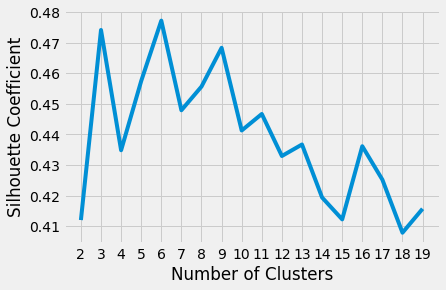

In [ ]:
scaler = StandardScaler()
scaled_features =scaler.fit_transform(db_to_normal_array(res))
# scaled_features=normalize(db_to_normal_array(res))
train_X=[0]*len(scaled_features)
for i in range(len(scaled_features)):
  train_X[i] = scaled_features[i][3:6]  
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(train_X)
    score = silhouette_score(train_X, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Save the model: K = 6 ,preprocessing = standardscaler , used feature : 

In [ ]:
scaler = StandardScaler()
scaled_features =scaler.fit_transform(db_to_normal_array(res))
# scaled_features=normalize(db_to_normal_array(res))
train_X=[0]*len(scaled_features)
for i in range(len(scaled_features)):
  train_X[i] = scaled_features[i][4:7]  
kmeans = KMeans(
     init="k-means++",
     n_clusters=6,
     n_init=10,
     max_iter=300,
     random_state=42
 )
kmeans.fit(train_X)
score = silhouette_score(train_X, kmeans.labels_)
print(score) 
joblib.dump(kmeans,"Kstd6.pkl")

RFclassifier

In [ ]:
#define model 
RFmodel = RandomForestClassifier(n_estimators=200, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(train_X, y_kmeans, test_size = 0.3, random_state = 42)
RFmodel.fit(X_train, y_train)

# Predict the Test set results

y_pred = RFmodel.predict(X_test)

# Check accuracy score 
joblib.dump(RFmodel,"RFmodel.pkl") 
print((accuracy_score(y_test, y_pred)))

0.9985038898862957


KNNclassifier

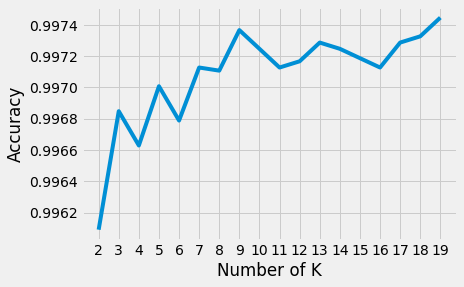

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y_kmeans, test_size = 0.3, random_state = 42)
acc=[]
for k in range(2, 20):
    knnmodel = KNeighborsClassifier(k)
    knnmodel.fit(X_train, y_train)
    y_pred = knnmodel.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), acc)
plt.xticks(range(2, 20))
plt.xlabel("Number of K")
plt.ylabel("Accuracy")
plt.show()
 
 

Multi-layer Perceptron classifier

In [ ]:
MLPmodel=MLPClassifier(random_state=1, max_iter=300) 
X_train, X_test, y_train, y_test = train_test_split(train_X, y_kmeans, test_size = 0.3, random_state = 42)
MLPmodel.fit(X_train, y_train)
y_pred = MLPmodel.predict(X_test)
joblib.dump(MLPmodel,"MLPmodel.pkl") 
print((accuracy_score(y_test, y_pred)))

0.9982246159984042


Support Vector Classifier

In [ ]:
svmmodel=svm.SVC()
X_train, X_test, y_train, y_test = train_test_split(train_X, y_kmeans, test_size = 0.3, random_state = 42)
svmmodel.fit(X_train, y_train)
y_pred = svmmodel.predict(X_test)
joblib.dump(svmmodel,"svmmodel.pkl") 
print((accuracy_score(y_test, y_pred)))

0.9987432675044884


# **Below is an code snippet for applying the Kmeans and RF**

In [ ]:
result,uri=preprocess_playlist_1(user_playlist) # user_playlist is a csv
songs=get_std_playlist(result,res) # song = preprocessed input playlist with standarscaler
test_X=[]
######################## Feature selection : select feature from 3 to 5  which are speechiness,acousticness,and instrumentalness
for i in range(len(result)):
    test_X.append(songs[i][3:6])

pre_y=RFmodel.predict(test_X) # pre_y are predicted lables for input playlist

# Please use standardscaler() as the preprocessing method since our Kmeans and RF are basedon standardscaler()
# Note: You need to ensure the input song exsit in the database,if not,append the input songs into the database(or tuple) , and do standardscaler() to the database. And then retrieve the input playlist from database so you can do KNN.
If you do seperately do standardscaler() to input playlist and database, the recommending will be shitty. 

In [ ]:
mood=["Unsure","Happy","Romantic","Sad","Focused","Energetic"]

In [ ]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
count_5=0

index_0=[]
index_1=[]
index_2=[]
index_3=[]
index_4=[]
index_5=[]
for i in range(len(y_kmeans)):
  if y_kmeans[i] == 0 :
    count_0=count_0+1
    index_0.append(i)
  elif y_kmeans[i] == 1 :
    count_1=count_1+1
    index_1.append(i)
  elif y_kmeans[i] == 2 :
    count_2=count_2+1
    index_2.append(i)
  elif y_kmeans[i] == 3 :
    count_3=count_3+1
    index_3.append(i)
  elif y_kmeans[i] == 4 :
    count_4=count_4+1
    index_4.append(i)
  elif y_kmeans[i] == 5 :
    count_5=count_5+1
    index_5.append(i)
print("Cluster 0: "+str(count_0)+"\nCluster 1: "+str(count_1)+"\nCluster 2: "+str(count_2)+
   "\nCluster 3: "+str(count_3)+"\nCluster 4: "+str(count_4)+"\nCluster 5: "+str(count_5))
 

Cluster 0: 2542
Cluster 1: 17542
Cluster 2: 21651
Cluster 3: 38344
Cluster 4: 12398
Cluster 5: 74623


# Example of identifying a mood: test with energy songs

In [ ]:
############################## Verify the mood with the RFmodel
user_playlist=pd.read_csv('sad.csv')
result,uri=preprocess_playlist_1(user_playlist)
songs=get_std_playlist(result,res)
test_X=[]
for i in range(len(result)):
    test_X.append(songs[i][3:6])
RFmodel= joblib.load("RFmodel.pkl")
pre_y=RFmodel.predict(test_X)
count=0
for i in range(len(pre_y)):
  if pre_y[i] == 5:
    count=count+1
print("Accuracy:"+str(count/len(pre_y)))
  


Accuracy:0.83


In [ ]:
def recommender(playlist,db):
  list_of_uri=[]
  list_of_songs=[]
  l=len(playlist)
  result,uri=preprocess_playlist_1(playlist)
  test_X=normalize(playlist_to_normal_array(result)) #Normalization 
  norm_db=normalize(db_to_normal_array(db))     #Normalization
 
  ##################################################### clustering
  # model=joblib.load("K6Norm.pkl")  # K = 6, features used: 0~8  ,Score = 0.26
  # y_pl=model.predict(test_X)
  # y_db=model.predict(norm_db)

   
  ###############################     K = 9 ,feature used: 345 , score = 0.46
  model = joblib.load("9Norm345.pkl")
  temp=[0]*len(db) 
  tmp=[0]*len(result)
  for i in range(len(db)):
    temp[i]=norm_db[i][3:6]
  for i in range(len(result)):
    tmp[i]=test_X[i][3:6]
  y_pl=model.predict(tmp)
  y_db=model.predict(temp)
  ################################
  ####################################################
  

  for i in range(l):
    distances = cdist(test_X[i].reshape(1,-1),norm_db,'cosine') #calculating Euclidean distance
    index = list(np.argsort(distances)[:, :10][0])

    # distances =  cosine_similarity(test_X[i].reshape(1,-1),norm_db) #Calculating Cosine similarity
    # index = list(np.argsort(-distances)[:, :10][0])  
   
    for num in index:
      if uri[i] != db[num][0] and y_pl[i] ==y_db[num]: 
        list_of_uri.append(db[num][0])
          
          
  for i in range(len(list_of_uri)):    
          result=sp.track(list_of_uri[i]) 
          list_of_songs.append([list_of_uri[i]])
          list_of_songs[i].append(result["name"])
          list_of_songs[i].append(result["artists"][0]["name"])
          list_of_songs[i].append(result['popularity'])

 
  for i in range(len(list_of_songs))[::-1]:
    if list_of_songs[i][3] < 20:
      list_of_songs.pop(i)        
  out=pd.DataFrame(list_of_songs,columns=[ 'URI','Song','Artist' ,'Popularity'])
  out.set_index('URI', inplace=True)
  return out.sort_values(by=['Popularity'],ascending=False)
 
  
   
recommender(demo,res)

,Song,Artist,Popularity
URI,,,
4JiEyzf0Md7KEFFGWDDdCr,Knockin' On Heaven's Door,Guns N' Roses,77
4S7YHmlWwfwArgd8LfSPud,L$D,A$AP Rocky,73
0lIoY4ZQsdn5QzhraM9o9u,Because the Night,Patti Smith,68
3GhsBdS9ulPK3KCdwHRPhG,Nothing's Gonna Hurt You Baby,Cigarettes After Sex,65
0XOnMqLQDO89iAg7dWWwnG,pete davidson,Ariana Grande,60
0LO7f7ZJg871B8hLTRzrfB,Julia,Mt. Joy,59
3xvcFlh6hHqxyiAFkqpsjZ,Always and Forever,Luther Vandross,55
3mBCTEzhxcv6jLaxXoOvWs,Moondust - Stripped,Jaymes Young,54
0Qbc2tyiSclb6vYvOxvebM,Warm Love,Van Morrison,53
